<a href="https://colab.research.google.com/github/aneeq-shaffy/DL-labsheets/blob/main/lab_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autonomous driving - Car detection

Welcome to your week 3 programming assignment. You will learn about object detection using the very powerful YOLO model. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242).

**You will learn to**:
- Use object detection on a car detection dataset
- Deal with bounding boxes

Run the following cell to load the packages and dependencies that are going to be useful for your journey!

In [49]:
!pip install tensorflow==2.16.1

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To simplify the loading of files and folders, we can load all files and directories from a zip file in google drive.

In [51]:
!unzip '/content/Archive.zip'  #Change the zip file name as needed

Archive:  /content/Archive.zip
replace __MACOSX/._yad2k? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._yad2k        
  inflating: __MACOSX/yad2k/._utils  
  inflating: __MACOSX/yad2k/._models  
  inflating: yad2k/utils/__init__.py  
  inflating: __MACOSX/yad2k/utils/.___init__.py  
  inflating: __MACOSX/yad2k/utils/.___pycache__  
  inflating: yad2k/utils/utils.py    
  inflating: __MACOSX/yad2k/utils/._utils.py  
  inflating: yad2k/models/keras_darknet19.py  
  inflating: __MACOSX/yad2k/models/._keras_darknet19.py  
  inflating: __MACOSX/yad2k/models/.___pycache__  
  inflating: yad2k/models/keras_yolo.py  
  inflating: __MACOSX/yad2k/models/._keras_yolo.py  
  inflating: yad2k/utils/__pycache__/__init__.cpython-39.pyc  
  inflating: __MACOSX/yad2k/utils/__pycache__/.___init__.cpython-39.pyc  
  inflating: yad2k/utils/__pycache__/utils.cpython-39.pyc  
  inflating: __MACOSX/yad2k/utils/__pycache__/._utils.cpython-39.pyc  
  inflating: yad2k/utils/__pycache__/utils.cp

In [52]:
#!pip list
import sys
sys.path.append('/content/drive/MyDrive/Lab 4/Lab 4_ 2025')
import yolo_utils
import importlib
importlib.reload(yolo_utils)

<module 'yolo_utils' from '/content/yolo_utils.py'>

In [53]:
import argparse, os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf

# Use tf.keras everywhere
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.models import load_model, Model


from yolo_utils import (
    read_classes, read_anchors, generate_colors,
    preprocess_image, draw_boxes, scale_boxes
)
from yad2k.models.keras_yolo import (
    yolo_head, yolo_boxes_to_corners,
    preprocess_true_boxes, yolo_loss, yolo_body
)





**Important Note**: As you can see, we import Keras's backend as K. This means that to use a Keras function in this notebook, you will need to write: `K.function(...)`.

## 1 - Problem Statement

You are working on a self-driving car. As a critical component of this project, you'd like to first build a car detection system. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around.

<center>
<video width="400" height="200" src="https://github.com/enggen/Deep-Learning-Coursera/blob/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> We would like to especially thank [drive.ai](https://www.drive.ai/) for providing this dataset! Drive.ai is a company building the brains of self-driving vehicles.
</center></caption>

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/driveai.png" style="width:100px;height:100;">

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/box_label.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>

If you have 80 classes that you want YOLO to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how YOLO works, then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights for you to use.

## 2 - YOLO

YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 2.1 - Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers.

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

Lets look in greater detail at what this encoding represents.

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>

Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture:

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each of the 19x19 grid cells colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm.


Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression. Specifically, you'll carry out these steps:
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.



### 2.2 - Filtering with a threshold on class scores

You are going to apply a first filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold.

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

**Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4. The following code may help you choose the right operator:
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # shape of c will be (19*19, 5, 80)
```
2. For each box, find:
    - the index of the class with the maximum box score ([Hint](https://keras.io/backend/#argmax)) (Be careful with what axis you choose; consider using axis=-1)
    - the corresponding box score ([Hint](https://keras.io/backend/#max)) (Be careful with what axis you choose; consider using axis=-1)
3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep.
4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep. ([Hint](https://www.tensorflow.org/api_docs/python/tf/boolean_mask))

Reminder: to call a Keras function, you should use `K.function(...)`.

In [54]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.

    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box

    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold.
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence * box_class_probs # (19, 19, 5, 80)
    ### END CODE HERE ###

    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores, axis=-1)  # (19, 19, 5)
    box_class_scores = K.max(box_scores, axis=-1) # (19, 19, 5)
    ### END CODE HERE ###

    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = box_class_scores >= threshold  # (19, 19, 5)
    # print(filtering_mask.shape)
    # print(box_class_scores.shape)
    ### END CODE HERE ###

    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    print (scores,boxes, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###

    return scores, boxes, classes

In [83]:
with tf.compat.v1.Session() as test_a:
    box_confidence = tf.compat.v1.random_normal([19, 19, 5, 1], mean=5, stddev=2, seed = 1)
    boxes = tf.compat.v1.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.compat.v1.random_normal([19, 19, 5, 80], mean=5, stddev=2, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.8)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))
    print(boxes.eval().shape)

Tensor("boolean_mask_27/GatherV2:0", shape=(None,), dtype=float32) Tensor("random_normal_34:0", shape=(19, 19, 5, 4), dtype=float32) Tensor("GreaterEqual_9:0", shape=(19, 19, 5), dtype=bool)
scores[2] = 44.953026
boxes[2] = [-1.8915889   0.7749185   3.5741792  -0.05729628]
classes[2] = 72
scores.shape = (None,)
boxes.shape = (None, 4)
classes.shape = (None,)
(1796, 4)


In [56]:
# box_confidence = tf.compat.v1.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
# boxes = tf.compat.v1.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
# box_class_probs = tf.compat.v1.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
# scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)

# # Start an interactive session
# sess = tf.compat.v1.InteractiveSession()
# print("boxes[2] = " + str(boxes[2].eval()))
# sess.close()

**Expected Output**:

<table>
    <tr>
        <td>
            **scores[2]**
        </td>
        <td>
           10.7506
        </td>
    </tr>
    <tr>
        <td>
            **boxes[2]**
        </td>
        <td>
           [ 8.42653275  3.27136683 -0.5313437  -4.94137383]
        </td>
    </tr>

    <tr>
        <td>
            **classes[2]**
        </td>
        <td>
           7
        </td>
    </tr>
        <tr>
        <td>
            **scores.shape**
        </td>
        <td>
           (?,)
        </td>
    </tr>
    <tr>
        <td>
            **boxes.shape**
        </td>
        <td>
           (?, 4)
        </td>
    </tr>

    <tr>
        <td>
            **classes.shape**
        </td>
        <td>
           (?,)
        </td>
    </tr>

</table>

### 2.3 - Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS).

<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 7** </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="https://raw.githubusercontent.com/enggen/Deep-Learning-Coursera/master/Convolutional%20Neural%20Networks/Week3/Car%20detection%20for%20Autonomous%20Driving/nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 8** </u>: Definition of "Intersection over Union". <br> </center></caption>

**Exercise**: Implement iou(). Some hints:
- In this exercise only, we define a box using its two corners (upper left and lower right): `(x1, y1, x2, y2)` rather than the midpoint and height/width.
- To calculate the area of a rectangle you need to multiply its height `(y2 - y1)` by its width `(x2 - x1)`.
- You'll also need to find the coordinates `(xi1, yi1, xi2, yi2)` of the intersection of two boxes. Remember that:
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes
- In order to compute the intersection area, you need to make sure the height and width of the intersection are positive, otherwise the intersection area should be zero. Use `max(height, 0)` and `max(width, 0)`.

In this code, we use the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) the lower-right corner.

In [57]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2

    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 5 lines)
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(yi2-yi1, 0) * max(xi2-xi1, 0)
    ### END CODE HERE ###

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[3] - box1[1]) *  (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) *  (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###

    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area / union_area
    ### END CODE HERE ###

    return iou

In [58]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


**Expected Output**:

<table>
    <tr>
        <td>
            **iou = **
        </td>
        <td>
           0.14285714285714285
        </td>
    </tr>

</table>

Non-max suppression (NMS)

We use TensorFlow’s built-in NMS to keep only the most confident, non-overlapping boxes.

Procedure

Convert scores, boxes (format: (y1, x1, y2, x2)), and classes to tensors.

Call tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes, iou_threshold=iou_threshold) to get the indices of boxes to keep. Internally, TF repeatedly selects the highest-score box and removes any box whose IoU with it exceeds the threshold.

(Optional) Sort the kept indices for stable ordering.

Use tf.gather to pick the filtered scores, boxes, and classes by those indices.

Return the filtered tensors and the selected indices.

Notes

Runs in eager mode (no sessions, no .eval()).

Uses tf.image.non_max_suppression and tf.gather (not keras.backend).

boxes must be in (y1, x1, y2, x2) format.

In [59]:
# GRADED FUNCTION: yolo_non_max_suppression

import tensorflow as tf

def yolo_non_max_suppression(scores, boxes, classes, max_boxes=20, iou_threshold=0.5):
    """
    scores:  [N] or [N,] tensor/ndarray
    boxes:   [N,4] in (y1, x1, y2, x2) format expected by tf.image.non_max_suppression
    classes: [N]
    """
    scores  = tf.convert_to_tensor(scores, dtype=tf.float32)
    boxes   = tf.convert_to_tensor(boxes,  dtype=tf.float32)
    classes = tf.convert_to_tensor(classes)

    # NMS returns indices to keep
    selected = tf.image.non_max_suppression(
        boxes=boxes,
        scores=scores,
        max_output_size=int(max_boxes),
        iou_threshold=float(iou_threshold)
    )

    # (optional) keep them sorted
    selected = tf.sort(selected)

    # gather filtered outputs
    boxes_f   = tf.gather(boxes, selected)
    scores_f  = tf.gather(scores, selected)
    classes_f = tf.gather(classes, selected)
    return scores_f, boxes_f, classes_f, selected


In [60]:

# Eager-friendly test (no sessions)
scores = tf.random.normal([54], mean=1.0, stddev=4.0, seed=1)
boxes  = tf.random.normal([54, 4], mean=1.0, stddev=4.0, seed=1)
classes = tf.random.normal([54], mean=1.0, stddev=4.0, seed=1)

scores_o, boxes_o, classes_o, indices_b = yolo_non_max_suppression(scores, boxes, classes)

print("scores[2] =", float(scores_o.numpy()[2]))
print("boxes[2]  =", boxes_o.numpy()[2].tolist())
print("classes[2] =", float(classes_o.numpy()[2]))
print("indices of boxes =", indices_b.numpy().tolist())
print("scores.shape =", scores_o.shape)
print("boxes.shape  =", boxes_o.shape)
print("classes.shape =", classes_o.shape)


scores[2] = 3.458220958709717
boxes[2]  = [1.0012277364730835, -0.9701807498931885, -2.1082279682159424, 6.400643348693848]
classes[2] = 6.384605407714844
indices of boxes = [0, 3, 5, 7, 8, 10, 18, 21, 22, 23, 25, 26, 31, 34, 36, 39, 40, 47, 48, 51]
scores.shape = (20,)
boxes.shape  = (20, 4)
classes.shape = (20,)


**Expected Output**:

<table>
    <tr>
        <td>
            **scores[2]**
        </td>
        <td>
           6.9384
        </td>
    </tr>
    <tr>
        <td>
            **boxes[2]**
        </td>
        <td>
           [-5.299932    3.13798141  4.45036697  0.95942086]
        </td>
    </tr>

    <tr>
        <td>
            **classes[2]**
        </td>
        <td>
           -2.24527
        </td>
    </tr>
        <tr>
        <td>
            **scores.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>
    <tr>
        <td>
            **boxes.shape**
        </td>
        <td>
           (10, 4)
        </td>
    </tr>

    <tr>
        <td>
            **classes.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>

</table>

### 2.4 Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented.

**Exercise**: Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which we have provided):

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh)
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

Don't worry about these two functions; we'll show you where they need to be called.  

In [61]:
# GRADED FUNCTION: yolo_eval
#score threshold default 0.6
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.

    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering

    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """

    ### START CODE HERE ###

    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)

    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes, __ = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    ### END CODE HERE ###

    return scores, boxes, classes

In [62]:
with tf.compat.v1.Session() as test_b:
    yolo_outputs = (tf.compat.v1.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.compat.v1.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.compat.v1.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.compat.v1.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores   .shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))




Tensor("boolean_mask_24/GatherV2:0", shape=(None,), dtype=float32) Tensor("concat_5:0", shape=(19, 19, 5, 4), dtype=float32) Tensor("GreaterEqual_8:0", shape=(19, 19, 5), dtype=bool)
scores[2] = 138.79124
boxes[2] = [ 1978.7979  4552.177   5936.3936 13656.529 ]
classes[2] = 67
scores   .shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

<table>
    <tr>
        <td>
            **scores[2]**
        </td>
        <td>
           138.791
        </td>
    </tr>
    <tr>
        <td>
            **boxes[2]**
        </td>
        <td>
           [ 1292.32971191  -278.52166748  3876.98925781  -835.56494141]
        </td>
    </tr>

    <tr>
        <td>
            **classes[2]**
        </td>
        <td>
           54
        </td>
    </tr>
        <tr>
        <td>
            **scores.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>
    <tr>
        <td>
            **boxes.shape**
        </td>
        <td>
           (10, 4)
        </td>
    </tr>

    <tr>
        <td>
            **classes.shape**
        </td>
        <td>
           (10,)
        </td>
    </tr>

</table>

<font color='blue'>
**Summary for YOLO**:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output.
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers.
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture.
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output.

## 3 - Test YOLO pretrained model on images

In TensorFlow 2, eager execution is enabled by default. That means you don’t need to create a session to run the graph. Tensors evaluate immediately, and you can inspect their values with .numpy()

In [63]:
x = tf.random.normal([3, 3])
print(x)           # Eager tensor
print(x.numpy())   # Convert to NumPy array

tf.Tensor(
[[ 0.3318101  -1.2897651  -2.1584356 ]
 [ 0.29574633  0.73005205  0.07921472]
 [-0.35086963 -0.566824   -0.5225369 ]], shape=(3, 3), dtype=float32)
[[ 0.3318101  -1.2897651  -2.1584356 ]
 [ 0.29574633  0.73005205  0.07921472]
 [-0.35086963 -0.566824   -0.5225369 ]]


### 3.1 - Defining classes, anchors and image shape.

Recall that we are trying to detect 80 classes, and are using 5 anchor boxes. We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". Let's load these quantities into the model by running the next cell.

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images.

In [64]:
class_names = read_classes("/content/model_data/coco_classes.txt")
anchors = read_anchors("/content/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

### 3.2 - Loading a pretrained model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pretrained Keras YOLO model stored in "yolo.h5". (These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but we will more simply refer to it as "YOLO" in this notebook.) Run the cell below to load the model from this file.

In [65]:
#yolo_model = load_model("/content/drive/MyDrive/lab_5/yolo_v2.h5")
# 1) Make 'import keras' resolve to tf.keras (for YAD2K & yolo_utils)
import tensorflow as tf, sys
sys.modules['keras'] = tf.keras  # route legacy 'keras' imports to tf.keras

# 2) Build YOLOv2 body and load weights (no pickled functions)
from keras.layers import Input
from keras.models import Model
import numpy as np

# helpers from your project
from yolo_utils import read_classes, read_anchors
# from yad2k.models.keras_yolo import yolo_body # Comment out or remove this line

# paths in your repo
classes_path = "/content/model_data/coco_classes.txt"
anchors_path = "/content/model_data/yolo_anchors.txt"
weights_path = "/content/model_data/yolo_v2.h5"  # your weights file

# read metadata
class_names = read_classes(classes_path)
anchors = read_anchors(anchors_path)   # shape (num_anchors, 2)
num_classes = len(class_names)
num_anchors = anchors.shape[0]         # typically 5 for YOLOv2

# build model using the corrected function defined in the notebook
image_input = Input(shape=(None, None, 3))
yolo_model = yolo_body_corrected(image_input, num_anchors, num_classes)

# IMPORTANT: load only weights (avoids marshal/unpickle issues)
yolo_model.load_weights(weights_path)
print("Loaded YOLOv2 weights OK.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Loaded YOLOv2 weights OK.


This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains.

In [66]:
yolo_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, None,      │        128 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_88      │ (None, None,      │          0 │ norm_1[0][0]      │
│ (LeakyReLU)         │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, None,      │          0 │ leaky_re_lu_88[0… │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, None,      │     18,432 │ max_pooling2d_20… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, None,      │        256 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_89      │ (None, None,      │          0 │ norm_2[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, None,      │          0 │ leaky_re_lu_89[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, None,      │     73,728 │ max_pooling2d_21… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_3              │ (None, None,      │        512 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_90      │ (None, None,      │          0 │ norm_3[0][0]      │
│ (LeakyReLU)         │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, None,      │      8,192 │ leaky_re_lu_90[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_4              │ (None, None,      │        256 │ conv_4[0][0]      │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_91      │ (None, None,      │          0 │ norm_4[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, None,      │     73,728 │ leaky_re_lu_91[0… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_5              │ (None, None,      │        512 │ conv_5[0][0]    

 Total params: 50,983,561 (194.49 MB)

 Trainable params: 50,962,889 (194.41 MB)

 Non-trainable params: 20,672 (80.75 KB)

**Note**: On some computers, you may see a warning message from Keras. Don't worry about it if you do--it is fine.

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85) as explained in Figure (2).

### 3.3 - Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you.

In [67]:
# === 3.3 — Convert output of the model to usable bounding box tensors ===
import numpy as np
import tensorflow as tf
from yolo_utils import preprocess_image  # you already have this

def yolo_head_eager(feats, anchors, num_classes):
    """
    Convert final conv features to YOLOv2 head tensors (eager-safe).
    Accepts feats shaped either (B,S,S,A*(5+C)) or (B,S,S,A,5+C).
    Returns: (box_confidence, box_xy, box_wh, box_class_probs)
      box_confidence: (B,S,S,A,1)
      box_xy:         (B,S,S,A,2) in [0,1] normalized by grid (x,y)
      box_wh:         (B,S,S,A,2) in [0,1] normalized by grid (w,h)
      box_class_probs:(B,S,S,A,C)
    """
    feats = tf.convert_to_tensor(feats)
    dtype = feats.dtype
    anchors = tf.convert_to_tensor(np.array(anchors, dtype=np.float32), dtype=dtype)

    # Spatial dims
    conv_dims = tf.shape(feats)[1:3]   # (gh, gw)
    gh, gw = conv_dims[0], conv_dims[1]

    # Ensure anchor axis is explicit
    A = tf.shape(anchors)[0]
    last_dim = tf.shape(feats)[-1]
    expected = (num_classes + 5) * A
    feats = tf.cond(
        tf.equal(last_dim, expected),
        lambda: tf.reshape(feats, (-1, gh, gw, A, num_classes + 5)),
        lambda: feats
    )

    # Build grid (x,y)
    yy = tf.range(gh, dtype=dtype)
    xx = tf.range(gw, dtype=dtype)
    yy, xx = tf.meshgrid(yy, xx, indexing='ij')     # (S,S)
    grid = tf.stack([xx, yy], axis=-1)              # (S,S,2) -> (x,y)
    grid = tf.expand_dims(grid, 2)                  # (S,S,1,2)

    # Anchors and normalizers
    anchors_t = tf.reshape(anchors, [1,1,-1,2])     # (1,1,A,2)
    grid_norm = tf.reshape(tf.cast(tf.stack([gw, gh]), dtype), [1,1,1,2])

    # Raw predictions
    box_xy_raw   = feats[..., 0:2]
    box_wh_raw   = feats[..., 2:4]
    obj_logit    = feats[..., 4:5]
    class_logits = feats[..., 5:5+num_classes]

    # YOLOv2 transforms
    box_xy = (tf.sigmoid(box_xy_raw) + grid) / grid_norm
    box_wh = (tf.exp(box_wh_raw) * anchors_t) / grid_norm
    box_confidence  = tf.sigmoid(obj_logit)
    box_class_probs = tf.nn.softmax(class_logits, axis=-1)

    return box_confidence, box_xy, box_wh, box_class_probs

# --- Run one forward pass to get concrete tensors, then convert to YOLO heads ---
# Preprocess any image to get a batch (1,608,608,3); adjust path/size as you use in your lab.
img_path = "/content/images/test.jpg"  # <- change if needed
image_pil, image_batch = preprocess_image(img_path, model_image_size=(608, 608))

# Model forward (concrete tensor, NOT yolo_model.output)
raw_out = yolo_model(image_batch, training=False)   # shape: (1,19,19,425) or (1,19,19,5,85)

# Convert to usable bounding box tensors
yolo_outputs = yolo_head_eager(raw_out, anchors, len(class_names))
box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

print("Converted shapes:",
      "\n  box_confidence:", box_confidence.shape,
      "\n  box_xy:",         box_xy.shape,
      "\n  box_wh:",         box_wh.shape,
      "\n  box_class_probs:",box_class_probs.shape)


Converted shapes: 
  box_confidence: (1, 19, 19, 5, 1) 
  box_xy: (1, 19, 19, 5, 2) 
  box_wh: (1, 19, 19, 5, 2) 
  box_class_probs: (1, 19, 19, 5, 80)


You added `yolo_outputs` to your graph. This set of 4 tensors is ready to be used as input by your `yolo_eval` function.

### 3.4 - Filtering boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. You're now ready to perform filtering and select only the best boxes. Lets now call `yolo_eval`, which you had previously implemented, to do this.

In [68]:
import importlib, yolo_utils
importlib.reload(yolo_utils)


<module 'yolo_utils' from '/content/yolo_utils.py'>

In [69]:
from PIL import ImageDraw, ImageFont
import numpy as np
import yolo_utils

def draw_boxes_safe(image, out_scores, out_boxes, out_classes, class_names, colors):
    try:
        font = ImageFont.truetype('/content/lab_5/font/FiraMono-Medium.otf',
                                  size=int(np.floor(3e-2 * image.size[1] + 0.5)))
    except OSError:
        font = ImageFont.load_default()

    thickness = (image.size[0] + image.size[1]) // 300 or 1
    for i, c in reversed(list(enumerate(out_classes))):
        c = int(c)
        label = f"{class_names[c]} {float(out_scores[i]):.2f}"
        box = out_boxes[i]
        top, left, bottom, right = [int(x) for x in [
            max(0, np.floor(box[0] + 0.5)),
            max(0, np.floor(box[1] + 0.5)),
            min(image.size[1], np.floor(box[2] + 0.5)),
            min(image.size[0], np.floor(box[3] + 0.5)),
        ]]

        draw = ImageDraw.Draw(image)
        # text size (Pillow compatibility)
        if hasattr(draw, "textbbox"):
            l, t, r, b = draw.textbbox((0, 0), label, font=font)
            label_w, label_h = r - l, b - t
        else:
            label_w, label_h = draw.textsize(label, font=font)

        text_origin = (left, top - label_h) if top - label_h >= 0 else (left, top + 1)

        for t in range(thickness):
            draw.rectangle([left + t, top + t, right - t, bottom - t], outline=colors[c])
        draw.rectangle([text_origin, (text_origin[0] + label_w, text_origin[1] + label_h)],
                       fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

# use this instead of yolo_utils.draw_boxes
draw_boxes_safe(image_pil, scores.numpy(), boxes.numpy(), classes.numpy(), class_names, colors)

AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

### 3.5 - Run the graph on an image

Let the fun begin. You have created a (`sess`) graph that can be summarized as follows:

1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>

**Exercise**: Implement predict() which runs the graph to test YOLO on an image.
You will need to run a TensorFlow session, to have it compute `scores, boxes, classes`.

The code below also uses the following function:
```python
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
```
which outputs:
- image: a python (PIL) representation of your image used for drawing boxes. You won't need to use it.
- image_data: a numpy-array representing the image. This will be the input to the CNN.

**Important note**: when a model uses BatchNorm (as is the case in YOLO), you will need to pass an additional placeholder in the feed_dict {K.learning_phase(): 0}.

Run the following cell on the "test.jpg" image to verify that your function is correct.

In [73]:
#2025 version
def predict_(image_file):
    """
    Run YOLO model on an image and return predictions (TF2/Keras version).
    """

    # Preprocess image
    image, image_data = preprocess_image(
        os.path.join("/content/images", image_file),
        model_image_size=(608, 608)
    )

    # Forward pass -> concrete output tensor
    raw_out = yolo_model(image_data, training=False)

    # Decode raw predictions into YOLO head tensors
    yolo_outputs = yolo_head_eager(raw_out, anchors, len(class_names))
    box_conf, box_xy, box_wh, box_class_probs = yolo_outputs

    # Evaluate: filter + NMS
    H, W = float(image.size[1]), float(image.size[0])
    scores, boxes, classes = yolo_eval(
        (box_conf, box_xy, box_wh, box_class_probs),
        (H, W),
        max_boxes=20,
        score_threshold=0.6,
        iou_threshold=0.5
    )

    # Print predictions info
    print(f"Found {boxes.shape[0]} boxes for {image_file}")

    # Generate colors
    colors = generate_colors(class_names)

    # Draw boxes
    # Convert tensors to NumPy arrays before passing to draw_boxes_safe
    draw_boxes_safe(image, scores.numpy(), boxes.numpy(), classes.numpy(), class_names, colors)

    # Save to out dir
    out_dir = "/content/out"
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, image_file)
    image.save(out_path, quality=90)

    # Display in notebook
    import imageio.v2 as imageio
    from matplotlib.pyplot import imshow
    output_image = imageio.imread(out_path)
    imshow(output_image)

    return scores.numpy(), boxes.numpy(), classes.numpy()

tf.Tensor(
[0.6700939  0.67649984 0.6270605  0.6045464  0.74766463 0.7985392
 0.8925936  0.69886523], shape=(8,), dtype=float32) tf.Tensor(
[[[[[ 1.40155172e-02  1.59371458e-02  3.25047635e-02  3.40473875e-02]
    [ 2.85089761e-03 -3.47940251e-03  7.08847865e-02  8.53934437e-02]
    [-1.10636503e-01 -1.05346814e-02  1.86767101e-01  8.14489424e-02]
    [-8.16963986e-03 -1.58354133e-01  7.84295797e-02  2.14298308e-01]
    [-2.38317698e-01 -2.35384420e-01  3.03038865e-01  2.85890222e-01]]

   [[ 4.57779784e-03  4.35787104e-02  1.06276795e-02  1.11179769e-01]
    [ 8.27772170e-03  5.01223654e-03  4.75238450e-02  1.46397620e-01]
    [-6.36451542e-02  2.23293900e-05  1.40391946e-01  1.48248374e-01]
    [-3.01816687e-03 -1.08130731e-01  6.66787177e-02  2.65298814e-01]
    [-1.97679669e-01 -1.73166454e-01  2.58000970e-01  3.34740400e-01]]

   [[ 6.80206297e-03  1.03988245e-01  1.16815530e-02  1.59785673e-01]
    [ 8.10412131e-03  2.37280056e-02  3.61908227e-02  2.35048622e-01]
    [-6.32452294

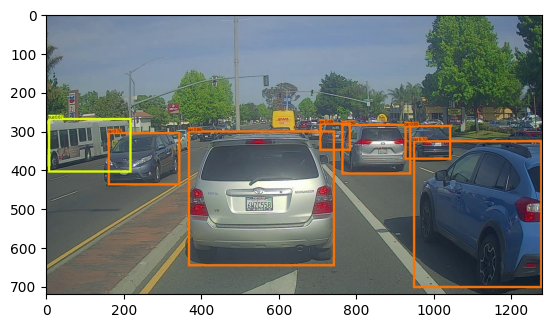

In [74]:
out_scores, out_boxes, out_classes = predict_("test.jpg")


In [75]:
def print_detections(scores, boxes, classes, class_names):
    # sort by score descending
    order = np.argsort(-scores)
    for i in order:
        y1, x1, y2, x2 = boxes[i].astype(int)
        print(f"{class_names[int(classes[i])]:<7}\t{scores[i]:.2f} ({x1}, {y1}) ({x2}, {y2})")

# example:
print_detections(out_scores, out_boxes, out_classes, class_names)


car    	0.89 (366, 299) (745, 647)
car    	0.80 (761, 281) (942, 411)
car    	0.75 (158, 302) (346, 440)
car    	0.70 (947, 323) (1288, 704)
car    	0.68 (705, 279) (785, 350)
bus    	0.67 (4, 266) (220, 407)
car    	0.60 (925, 285) (1045, 373)


**Expected Output**:

<table>
    <tr>
        <td>
            **Found 7 boxes for test.jpg**
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.60 (925, 285) (1045, 374)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.66 (706, 279) (786, 350)
        </td>
    </tr>
    <tr>
        <td>
            **bus**
        </td>
        <td>
           0.67 (5, 266) (220, 407)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.70 (947, 324) (1280, 705)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.74 (159, 303) (346, 440)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.80 (761, 282) (942, 412)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.89 (367, 300) (745, 648)
        </td>
    </tr>
</table>

Output for some random images

tf.Tensor([0.7747109  0.7409659  0.6925146  0.71792805 0.63044393], shape=(5,), dtype=float32) tf.Tensor(
[[[[[ 6.53325347e-03  7.45666586e-03  1.89861525e-02  2.56896373e-02]
    [-6.16577454e-03 -6.19953126e-03  6.42898977e-02  8.54693428e-02]
    [-1.36528283e-01 -1.51113030e-02  2.00386375e-01  7.31863007e-02]
    [-1.40290838e-02 -1.70939058e-01  7.36152679e-02  2.26535052e-01]
    [-2.36845762e-01 -2.31287301e-01  3.05270582e-01  2.83322513e-01]]

   [[ 3.10335704e-03  6.38849586e-02  8.61640088e-03  9.99118686e-02]
    [ 2.55577639e-03  9.29259509e-03  4.46652919e-02  1.52593017e-01]
    [-9.92276967e-02  2.36951932e-02  1.65382564e-01  1.41462207e-01]
    [-1.34999622e-02 -9.77189392e-02  6.96855858e-02  2.63737381e-01]
    [-1.92337483e-01 -1.57487422e-01  2.61992872e-01  3.18639100e-01]]

   [[ 2.19464162e-03  1.00887701e-01  6.35648007e-03  1.58335999e-01]
    [ 4.14427370e-04  4.68707010e-02  3.33919860e-02  2.24290609e-01]
    [-7.85504729e-02  6.85142651e-02  1.39373615e-

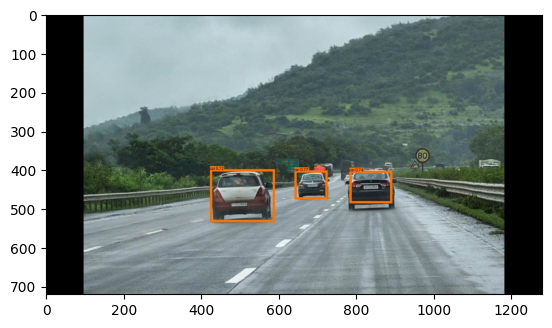

In [76]:
out_scores, out_boxes, out_classes = predict_("DSC_1643_resized.jpg")

Detect objects in all autonomous driving dataset images (i.e., 0100.jpg - 0120.jpg) in the images directory

In [77]:
!pwd
a = os.listdir('/content/images')
a

/content


['0119.jpg',
 '0115.jpg',
 '0118.jpg',
 'giraffe_resized.jpg',
 '0112.jpg',
 '0101.jpg',
 '0114.jpg',
 '0113.jpg',
 '0104.jpg',
 'DSC_1643_resized.jpg',
 '0106.jpg',
 '0120.jpg',
 '0105.jpg',
 '0111.jpg',
 '0109.jpg',
 '0116.jpg',
 '0103.jpg',
 '0108.jpg',
 '0107.jpg',
 '0110.jpg',
 '0100.jpg',
 '0102.jpg',
 '0117.jpg',
 'test.jpg']

Streaming output truncated to the last 5000 lines.
    [ 7.79536486e-01  7.93796301e-01  9.56636667e-01  1.04431581e+00]
    [ 6.16897285e-01  7.34675169e-01  1.10340357e+00  1.11133695e+00]]

   [[ 7.81504750e-01  9.87724721e-01  9.50271845e-01  9.95354474e-01]
    [ 7.60569453e-01  9.57576394e-01  9.63825941e-01  9.93211389e-01]
    [ 6.84850156e-01  9.32287574e-01  1.04279399e+00  9.96885300e-01]
    [ 7.92903662e-01  8.16155791e-01  9.43891644e-01  1.14194584e+00]
    [ 6.02196574e-01  7.50962496e-01  1.12582719e+00  1.20513296e+00]]]


  [[[ 8.58890116e-01  9.12459800e-04  9.84271586e-01  6.62795641e-03]
    [ 8.39176297e-01  1.63316354e-03  1.00062346e+00  4.36690040e-02]
    [ 7.48748124e-01 -4.80830669e-04  1.07264543e+00  7.04861507e-02]
    [ 8.54898214e-01 -1.49357602e-01  9.87410784e-01  2.04309866e-01]
    [ 6.33927345e-01 -2.25631863e-01  1.19880545e+00  2.83036321e-01]]

   [[ 9.01902556e-01  7.20416605e-02  9.25246119e-01  9.01465863e-02]
    [ 8.62009227e-01  2.5266785

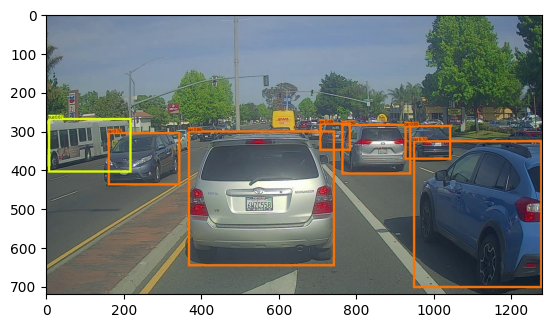

In [78]:
new_path = '/content/images'
for file_name in os.listdir(new_path):
  # if file_name[0] == '0': # images from [ 0100.jpg , 0120.jpg ]
  out_scores, out_boxes, out_classes = predict_(file_name)

Zip all output images and save the zip file to a folder in google drive for later use

In [80]:
import os
import zipfile
import shutil

directory = '/content/out'
zip_filename = '/content/out_score_0.6_iou_0.5_.zip'
dest_folder = '/content/drive/MyDrive/Lab_4_output'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    [zipf.write(os.path.join(directory, f), f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

os.makedirs(dest_folder, exist_ok=True)
shutil.copy2(zip_filename, dest_folder)

'/content/drive/MyDrive/Lab_4_output/out_score_0.6_iou_0.5_.zip'

The model you've just run is actually able to detect 80 different classes listed in "coco_classes.txt". To test the model on your own images:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the cell above code
    4. Run the code and see the output of the algorithm!

If you were to run your session in a for loop over all your images. Here's what you would get:

<center>
<video width="400" height="200" src="nb_images/pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Predictions of the YOLO model on pictures taken from a camera while driving around the Silicon Valley <br> Thanks [drive.ai](https://www.drive.ai/) for providing this dataset! </center></caption>

<font color='blue'>
**What you should remember**:
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume.
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically:
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise.

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website.
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/)

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. We are especially grateful to Brody Huval, Chih Hu and Rahul Patel for collecting and providing this dataset.

In [81]:
import tensorflow as tf

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in the output of yolo_head to the input shape

    Arguments:
    boxes -- tensor of shape (None, 4) containing the yolo_head predictions
    image_shape -- tensor of shape (2,) containing the input image shape

    Returns:
    boxes -- tensor of shape (None, 4) containing the scaled boxes
    """
    height = image_shape[0]
    width = image_shape[1]
    image_dims = tf.stack([height, width, height, width])
    image_dims = tf.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def space_to_depth_x2_corrected(x):
    # Corrected implementation using tf.compat.v1.space_to_depth
    import tensorflow as tf
    return tf.compat.v1.space_to_depth(x, block_size=2)

def yolo_body_corrected(inputs, num_anchors, num_classes):
    """Generate a YOLO V2 model

    Arguments:
        inputs: Input tensor.
        num_anchors: Number of anchor boxes.
        num_classes: Number of detection classes.

    Returns:
        model: A Keras model instance.
    """
    include_top = True
    # From https://github.com/fchollet/keras/blob/master/keras/applications/darknet19.py
    img_input = inputs
    # Block 1
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(img_input)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(128, (1, 1), strides=(1, 1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Block 6
    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Block 7
    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # This is the corrected space_to_depth layer
    skip_connection = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2_corrected)(skip_connection)

    x = concatenate([skip_connection, x])

    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(num_anchors * (num_classes + 5), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)

    return Model(img_input, x)